## Install Dependencies

In this cell, we install the Foolbox library, which is used for generating adversarial attacks. Foolbox provides a suite of tools to create adversarial examples using methods such as FGSM and PGD, enabling us to evaluate the robustness of our image classification models.


In [1]:
# Install the Foolbox library, which is used for generating adversarial attacks
!pip install foolbox


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.8 MB/s eta 0:00:00


## Step 1: Setup and Imports

In this cell, we import all the necessary libraries and modules required for our adversarial robustness evaluation pipeline. These include:

- **PyTorch and Torchvision:** For tensor operations, deep learning functionalities, and working with image datasets.
- **Pre-trained Models:** We import models like ResNet18 and MobileNetV2 from Torchvision, which will serve as our source and target models.
- **Visualization Libraries:** Matplotlib and Seaborn are used for plotting results and visualizing our findings.
- **Numerical Operations:** NumPy is imported for efficient numerical computation.
- **Progress Bars:** Tqdm helps in displaying progress during loops.
- **Foolbox:** This adversarial library is used to generate adversarial examples using techniques such as FGSM and PGD.
- **Data Handling:** DataLoader from PyTorch and Pandas for creating dataframes and managing our dataset.

The following code cell contains all these imports.


In [2]:
# STEP 1: SETUP AND IMPORTS

# Import PyTorch for tensor operations and deep learning functionalities
import torch

# Import torchvision for datasets and image transformations
import torchvision
import torchvision.transforms as transforms

# Import torch.nn for building neural network modules and torch.nn.functional for function-based operations
import torch.nn as nn
import torch.nn.functional as F

# Import pre-trained models: resnet18 and mobilenet_v2
from torchvision.models import resnet18, mobilenet_v2

# Import matplotlib and seaborn for plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import NumPy for numerical operations
import numpy as np

# Import tqdm for creating progress bars during loops
from tqdm.auto import tqdm

# Import Foolbox and its components for adversarial attack implementations
import foolbox as fb
import foolbox.attacks as fa
from foolbox.criteria import Misclassification

# Import DataLoader for batching the dataset during training/testing
from torch.utils.data import DataLoader

# Import pandas for data manipulation and analysis (e.g., creating DataFrames)
import pandas as pd


## Reproducibility and Device Setup

In this cell, we ensure that our experiments are reproducible by setting fixed random seeds for both PyTorch and NumPy. This helps to maintain consistency in our results across different runs. Additionally, we check if a GPU is available and set the device accordingly. If no GPU is found, the code will automatically fall back to using the CPU.


In [3]:
# Enable reproducibility by setting fixed random seeds for PyTorch and NumPy
torch.manual_seed(42)
np.random.seed(42)

# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


## Step 2: Load and Preprocess Dataset

In this cell, we load and preprocess the CIFAR-10 dataset for our experiments. The key steps include:

- **Transformation Pipeline:** We define a transformation using `transforms.Compose` to convert the images into PyTorch tensors.
- **Subset Selection:** To keep the training and testing manageable, we select a subset of 10,000 training samples and 1,000 test samples.
- **Dataset Loading:** The CIFAR-10 dataset is downloaded and loaded with the specified transformation.
- **Subset Creation:** We use `torch.randperm` to create random subsets from the full dataset.
- **DataLoaders:** DataLoaders are set up for both training and testing to efficiently batch and shuffle the data.
- **Class Names:** The CIFAR-10 class labels are defined for reference.
- **Dataset Size Check:** Finally, we print the sizes of the training and test subsets to confirm the correct number of samples.


In [4]:
# STEP 2: LOAD AND PREPROCESS DATASET

# Define a transformation pipeline to convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set subset sizes for a manageable training and testing dataset
subset_size = 10000  # Number of training samples to use
test_size = 1000     # Number of testing samples to use

# Load the CIFAR-10 training and test datasets with the defined transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Create random subsets from the full datasets using torch.randperm
train_indices = torch.randperm(len(trainset))[:subset_size]
test_indices = torch.randperm(len(testset))[:test_size]
trainset = torch.utils.data.Subset(trainset, train_indices)
testset = torch.utils.data.Subset(testset, test_indices)

# Create DataLoaders for training and testing with a batch size of 64
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Define the class names for the CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Print out the sizes of the training and test subsets
print(f"Training set size: {len(trainset)}")
print(f"Test set size: {len(testset)}")


100%|██████████| 170M/170M [00:02<00:00, 76.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set size: 10000
Test set size: 1000


## Step 3: Model Setup

In this step, we define and initialize our models:

1. **Source Model (Simplified ResNet):**  
   - We create a custom model by modifying a pre-trained ResNet18.  
   - The final fully connected layer is replaced to output 10 classes, matching the CIFAR-10 dataset.
   
2. **Target Model (MobileNetV2):**  
   - We initialize MobileNetV2 with pre-trained weights.
   - Its final classifier layer is replaced to output 10 classes, ensuring compatibility with CIFAR-10.

Both models are moved to the selected device (GPU or CPU) and set to evaluation mode to disable training-specific behaviors such as dropout.


In [5]:
# STEP 3: MODEL SETUP

# Define a simplified ResNet model by modifying the final fully connected layer
class SimplifiedResNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Load a pre-trained ResNet18 model
        self.resnet = resnet18(pretrained=True)
        # Replace the final fully connected layer to output 10 classes (for CIFAR-10)
        self.resnet.fc = nn.Linear(512, 10)

    def forward(self, x):
        # Forward pass through the modified ResNet model
        return self.resnet(x)

# Initialize the source model using our simplified ResNet and move it to the selected device
source_model = SimplifiedResNet().to(device)

# Initialize the target model using MobileNetV2 with pre-trained weights
target_model = mobilenet_v2(pretrained=True)
# Replace the final classifier layer to output 10 classes (for CIFAR-10)
target_model.classifier[1] = nn.Linear(target_model.last_channel, 10)
# Move the target model to the selected device
target_model = target_model.to(device)

# Set both models to evaluation mode to disable behaviors like dropout during inference
source_model.eval()
target_model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Step 4: Model Training

In this cell, we train both the source model and the target model using the CIFAR-10 dataset. We also define the number of workers for the DataLoader (set to 0 in this example to disable multiprocessing).

For training, we use:
- **CrossEntropyLoss** as the loss function for multi-class classification.
- **Adam optimizer** with a learning rate of 0.001.

**Training Process:**
- **Source Model Training:**  
  The source model (Simplified ResNet) is trained for 5 epochs. During each epoch:
  - The model is set to training mode.
  - The training data is iterated over in batches.
  - Inputs and labels are moved to the selected device (GPU/CPU).
  - A forward pass computes the predicted outputs.
  - The loss is computed between predicted outputs and true labels.
  - Backpropagation is performed to compute gradients.
  - The optimizer updates the model parameters.
  - The running loss is accumulated and the average loss is printed for each epoch.

- **Target Model Training:**  
  The target model (MobileNetV2) undergoes a similar training process for 5 epochs.


In [9]:
# STEP 4: MODEL TRAINING

# Define the number of workers to be used in DataLoader (set to 0 to disable multiprocessing)
num_workers = 0

# Train the source model
print("\nTraining source model...")
# Define the loss function (cross-entropy loss for multi-class classification)
criterion = nn.CrossEntropyLoss()
# Initialize the Adam optimizer with a learning rate of 0.001 for the source model
optimizer = torch.optim.Adam(source_model.parameters(), lr=0.001)

# Train for 5 epochs
for epoch in range(5):
    source_model.train()  # Set the model to training mode (enables dropout, batch norm updates, etc.)
    running_loss = 0.0  # Initialize variable to accumulate the loss over the epoch
    # Iterate over batches of data from the training loader with num_workers set to 0
    for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/5"):
        # Move inputs and labels to the selected device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Reset gradients from the previous step
        outputs = source_model(inputs)  # Forward pass: compute predicted outputs by passing inputs through the model
        loss = criterion(outputs, labels)  # Calculate the loss between predicted outputs and true labels
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Update model parameters based on computed gradients
        running_loss += loss.item()  # Accumulate the loss value
    # Print the average loss for the current epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.3f}")

# Train the target model
print("\nTraining target model...")
# Reinitialize the optimizer for the target model with the same learning rate
optimizer = torch.optim.Adam(target_model.parameters(), lr=0.001)
# Train for 5 epochs
for epoch in range(5):
    target_model.train()  # Set the target model to training mode
    running_loss = 0.0  # Initialize variable to accumulate the loss over the epoch
    # Iterate over batches of data from the training loader with num_workers set to 0
    for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/5"):
        # Move inputs and labels to the selected device
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Reset gradients before the current batch
        outputs = target_model(inputs)  # Forward pass: compute outputs for the current batch
        loss = criterion(outputs, labels)  # Calculate the loss between the outputs and the true labels
        loss.backward()  # Backward pass: compute the gradients for the current batch
        optimizer.step()  # Update the target model's parameters
        running_loss += loss.item()  # Accumulate the loss value
    # Print the average loss for the current epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.3f}")



Training source model...


Epoch 1/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1, Loss: 0.873


Epoch 2/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2, Loss: 0.649


Epoch 3/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3, Loss: 0.646


Epoch 4/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4, Loss: 0.394


Epoch 5/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5, Loss: 0.284

Training target model...


Epoch 1/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1, Loss: 1.347


Epoch 2/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2, Loss: 0.896


Epoch 3/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3, Loss: 0.749


Epoch 4/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4, Loss: 0.652


Epoch 5/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5, Loss: 0.629


## Step 5: Implement Attacks

In this cell, we implement adversarial attacks using the Foolbox library. The steps include:

- **Evaluation Mode:**  
  Both the source and target models are set to evaluation mode to disable training-specific behaviors (e.g., dropout, batch normalization updates).

- **Model Wrapping:**  
  We wrap the source and target models using Foolbox's `PyTorchModel` to enable the generation of adversarial examples. The `bounds` parameter is set to (0, 1) to indicate the valid input range for normalized images.

- **Attack Initialization:**  
  We initialize two adversarial attack methods:
  - **FGSM (Fast Gradient Sign Method):** A single-step attack that perturbs the input in the direction of the gradient.
  - **PGD (Projected Gradient Descent):** An iterative attack that refines adversarial examples over 20 steps.
  
These attacks will later be used to evaluate the robustness of our models.


In [10]:
# STEP 5: IMPLEMENT ATTACKS

# Ensure both models are in evaluation mode (disables training-specific behaviors)
source_model.eval()
target_model.eval()

# Wrap the source model with Foolbox's PyTorchModel for generating adversarial examples.
# The 'bounds' parameter sets the valid input range (0 to 1 for normalized images).
fmodel = fb.PyTorchModel(source_model, bounds=(0, 1))

# Similarly, wrap the target model for later evaluation and transferability analysis.
fmodel_target = fb.PyTorchModel(target_model, bounds=(0, 1))

# Initialize adversarial attacks using Foolbox:
fgsm = fa.FGSM()           # Fast Gradient Sign Method: a single-step attack that perturbs the input based on the gradient.
pgd = fa.PGD(steps=20)       # Projected Gradient Descent: an iterative attack that refines the adversarial example over 20 steps.


## Step 6: Evaluation

In this cell, we evaluate the performance of our source model under different conditions. We define a function `evaluate_model` that performs the following:

- **Model Evaluation:**  
  The model is set to evaluation mode to disable training-specific behaviors.

- **Adversarial Attack Application (Optional):**  
  If an adversarial attack is provided, the input images are perturbed using the specified attack (e.g., FGSM or PGD) before being passed to the model.

- **Prediction and Accuracy Calculation:**  
  The model's predictions are compared against the true labels, and overall accuracy is computed. Additionally, detailed results for each sample (true label, predicted label, and correctness) are recorded in a DataFrame.

We then use this function to:
1. Evaluate the source model on clean test images.
2. Evaluate the model under an FGSM attack.
3. Evaluate the model under a PGD attack.

The results (including accuracy and detailed predictions) will help us understand the impact of adversarial attacks on the model's performance.


In [11]:
# STEP 6: EVALUATION
print("\nEvaluating models...")

# Define a function to evaluate a model on a given dataset loader.
# Optionally, an adversarial attack can be applied to the input images.
def evaluate_model(model, loader, attack=None):
    model.eval()  # Set the model to evaluation mode
    correct = 0   # Initialize the counter for correct predictions
    total = 0     # Initialize the counter for total samples
    results = []  # List to store detailed results for each image

    # Iterate over the dataset using the provided DataLoader
    for images, labels in tqdm(loader):
        # Move images and labels to the designated device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        # If an attack is provided, generate adversarial examples
        if attack is not None:
            # The attack returns a tuple: (perturbed labels, perturbed images, additional info)
            _, images, _ = attack(fmodel, images, labels, epsilons=8/255)

        # Disable gradient computation for evaluation
        with torch.no_grad():
            outputs = model(images)          # Forward pass: get model predictions
            _, predicted = outputs.max(1)      # Get the predicted class for each image
            total += labels.size(0)            # Update total number of samples
            correct += predicted.eq(labels).sum().item()  # Count correct predictions

            # Record the true and predicted labels along with correctness for each sample
            for label, pred in zip(labels, predicted):
                results.append({
                    'true': label.item(),
                    'predicted': pred.item(),
                    'correct': label.item() == pred.item()
                })

    # Return a dictionary with overall accuracy and detailed results in a DataFrame
    return {
        'accuracy': 100 * correct / total,
        'results': pd.DataFrame(results)
    }

# Evaluate the source model on clean (unaltered) test images
clean_results = evaluate_model(source_model, testloader)
print(f"\nClean Accuracy: {clean_results['accuracy']:.2f}%")

# Evaluate the source model under FGSM attack
fgsm_results = evaluate_model(source_model, testloader, fgsm)
print(f"FGSM Attack Accuracy: {fgsm_results['accuracy']:.2f}%")

# Evaluate the source model under PGD attack
pgd_results = evaluate_model(source_model, testloader, pgd)
print(f"PGD Attack Accuracy: {pgd_results['accuracy']:.2f}%")



Evaluating models...


  0%|          | 0/16 [00:00<?, ?it/s]


Clean Accuracy: 67.90%


  0%|          | 0/16 [00:00<?, ?it/s]

FGSM Attack Accuracy: 4.40%


  0%|          | 0/16 [00:00<?, ?it/s]

PGD Attack Accuracy: 4.10%


## Step 7: Conceptual Differences Between Attacks

In this cell, we provide a detailed explanation of the conceptual differences between the two adversarial attack methods implemented:

In [12]:
# STEP 7: CONCEPTUAL DIFFERENCES BETWEEN ATTACKS

# Print header for analyzing the conceptual differences between adversarial attacks
print("\nAnalyzing Attack Differences...")

# Print detailed explanation outlining the differences between FGSM and PGD
print("""
FGSM (Fast Gradient Sign Method):
- Single-step attack that perturbs input in direction of gradient
- Faster but less effective than iterative attacks
- Uses sign of gradient to determine perturbation direction
- Epsilon parameter controls perturbation magnitude

PGD (Projected Gradient Descent):
- Iterative attack that performs multiple small steps
- More powerful but computationally intensive
- Projects perturbations onto allowed epsilon-ball
- Multiple parameters: steps, step size, and epsilon
""")



Analyzing Attack Differences...

FGSM (Fast Gradient Sign Method):
- Single-step attack that perturbs input in direction of gradient
- Faster but less effective than iterative attacks
- Uses sign of gradient to determine perturbation direction
- Epsilon parameter controls perturbation magnitude

PGD (Projected Gradient Descent):
- Iterative attack that performs multiple small steps
- More powerful but computationally intensive
- Projects perturbations onto allowed epsilon-ball
- Multiple parameters: steps, step size, and epsilon



## Step 8: Transferability Analysis

In this cell, we investigate the transferability of adversarial examples. Transferability analysis examines whether adversarial examples crafted for one model (in this case, the source model) can also fool a different pre-trained model (the target model). We evaluate the target model's performance on:

- Clean test images.
- Adversarial examples generated using FGSM.
- Adversarial examples generated using PGD.

The results will help us understand how adversarial vulnerabilities can persist across different model architectures.


In [13]:
# STEP 8: TRANSFERABILITY ANALYSIS

# Print header for transferability analysis
print("\nAnalyzing attack transferability...")

# Evaluate the target model on clean (unaltered) test images
target_clean = evaluate_model(target_model, testloader)
print(f"Target Model Clean Accuracy: {target_clean['accuracy']:.2f}%")

# Evaluate the target model using adversarial examples generated by FGSM on the source model
transfer_fgsm = evaluate_model(target_model, testloader, fgsm)
print(f"FGSM Transfer Accuracy: {transfer_fgsm['accuracy']:.2f}%")

# Evaluate the target model using adversarial examples generated by PGD on the source model
transfer_pgd = evaluate_model(target_model, testloader, pgd)
print(f"PGD Transfer Accuracy: {transfer_pgd['accuracy']:.2f}%")



Analyzing attack transferability...


  0%|          | 0/16 [00:00<?, ?it/s]

Target Model Clean Accuracy: 76.60%


  0%|          | 0/16 [00:00<?, ?it/s]

FGSM Transfer Accuracy: 43.40%


  0%|          | 0/16 [00:00<?, ?it/s]

PGD Transfer Accuracy: 59.20%


## Step 9: Visualization

In this cell, we generate several visualizations to help us understand the impact of adversarial attacks on our model's performance:

1. **Accuracy Comparison Bar Chart:**  
   We create a bar chart to compare the model's accuracy under different conditions:
   - Clean test images.
   - Adversarial examples generated using FGSM.
   - Adversarial examples generated using PGD.
   - Transfer attacks on the target model using FGSM and PGD.

2. **Confusion Matrix:**  
   We visualize a confusion matrix for the FGSM attack results to analyze which classes are more often misclassified under attack.

3. **Sample Images Visualization:**  
   We display a grid of sample images showing the original images alongside their FGSM and PGD adversarial counterparts. This helps in visually assessing the perturbations introduced by the attacks.


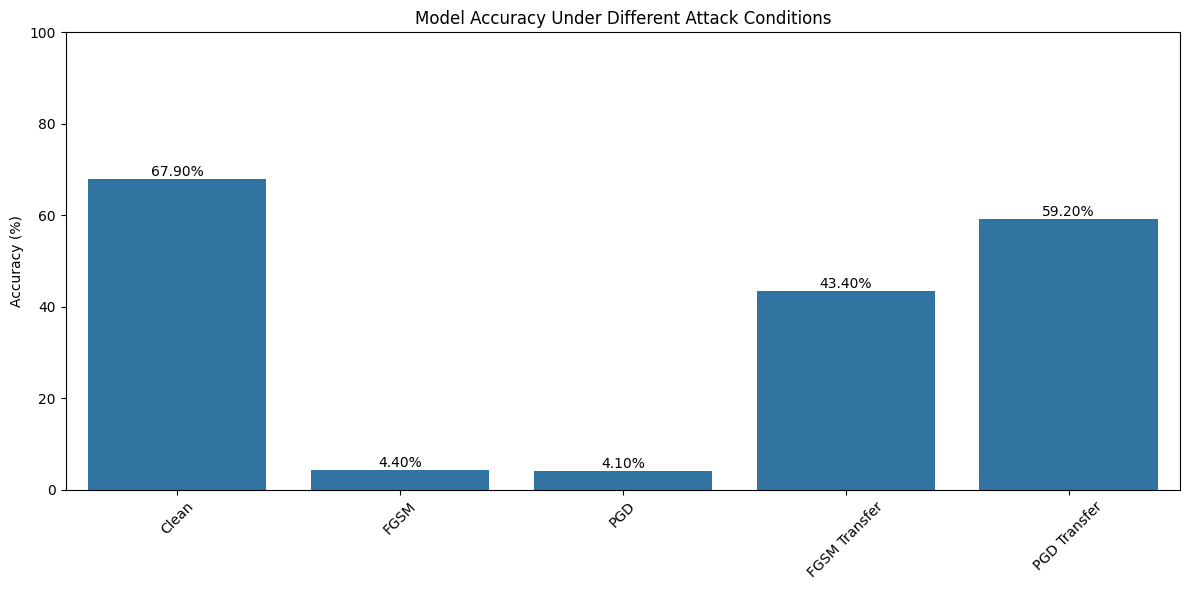

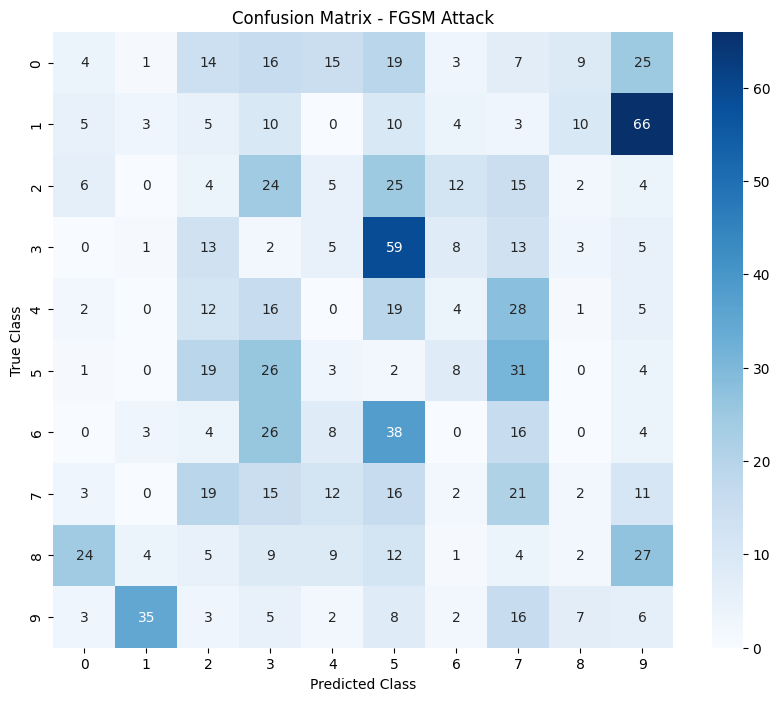

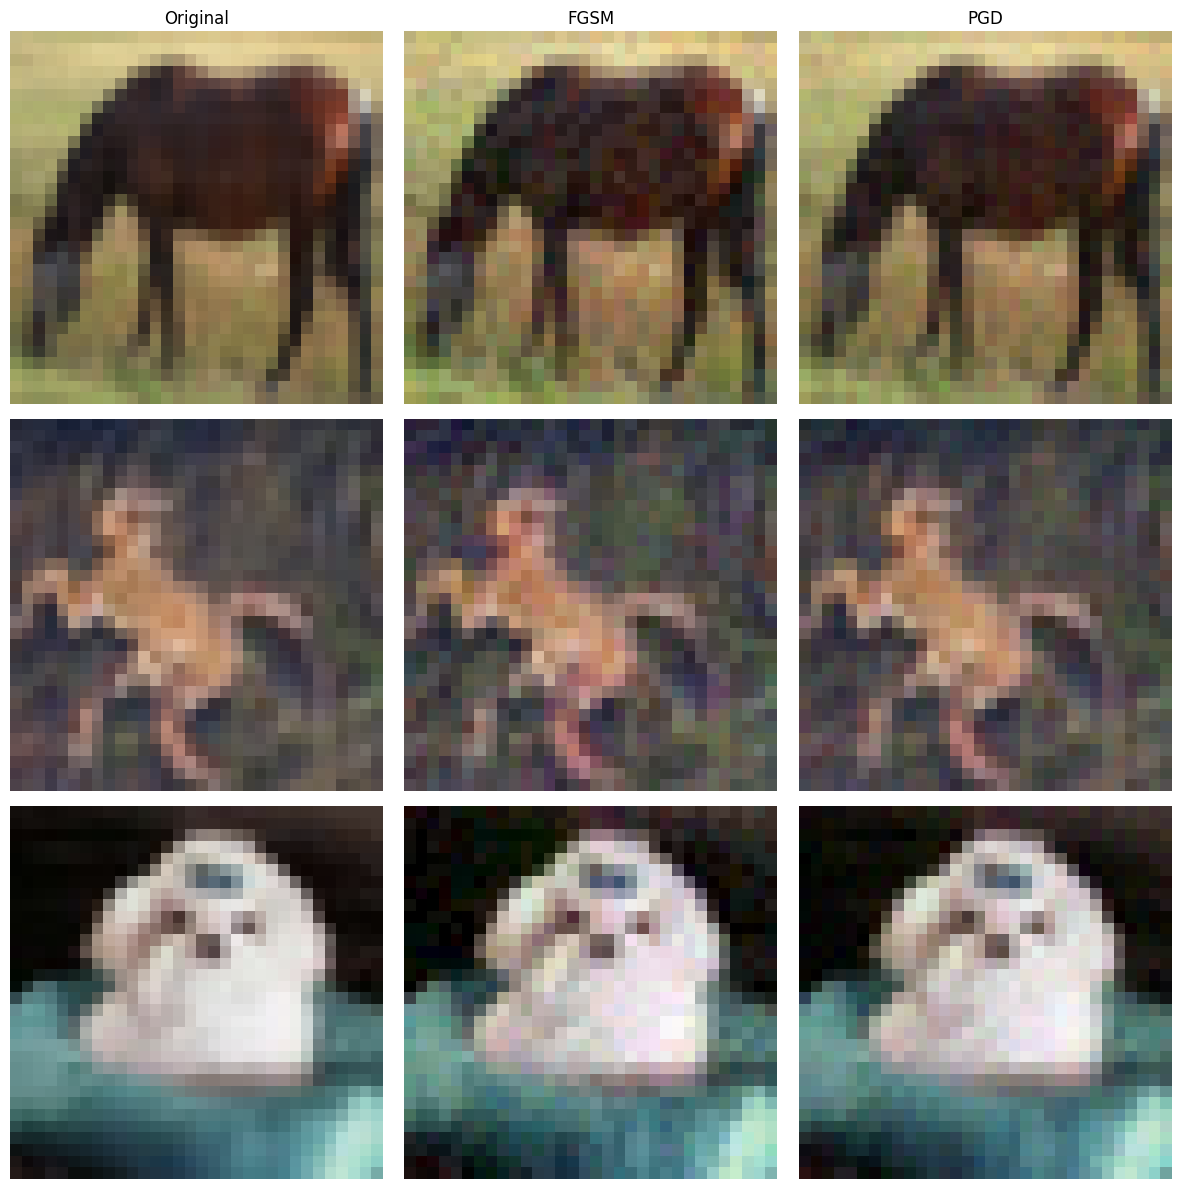

In [14]:
# STEP 9: VISUALIZATION

# Accuracy comparison plot
plt.figure(figsize=(12, 6))  # Set the figure size for the bar plot
# Define the labels for each method/attack condition
methods = ['Clean', 'FGSM', 'PGD', 'FGSM Transfer', 'PGD Transfer']
# Collect the accuracy results from evaluations
accuracies = [
    clean_results['accuracy'],
    fgsm_results['accuracy'],
    pgd_results['accuracy'],
    transfer_fgsm['accuracy'],
    transfer_pgd['accuracy']
]

# Create a bar plot using seaborn to compare accuracies across different attack conditions
sns.barplot(x=methods, y=accuracies)
plt.title('Model Accuracy Under Different Attack Conditions')  # Set the title of the plot
plt.ylabel('Accuracy (%)')  # Label for the y-axis
plt.ylim(0, 100)  # Set the y-axis limit from 0 to 100
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Annotate each bar with the corresponding accuracy value
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f'{acc:.2f}%', ha='center', va='bottom')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()  # Display the bar plot

# Confusion matrix visualization for FGSM attack results
plt.figure(figsize=(10, 8))  # Set the figure size for the heatmap
# Create a confusion matrix DataFrame by cross-tabulating true vs. predicted labels from FGSM results
conf_matrix = pd.crosstab(
    fgsm_results['results']['true'],
    fgsm_results['results']['predicted']
)
# Plot the confusion matrix using seaborn's heatmap with annotations and a blue color palette
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - FGSM Attack')  # Set title of the heatmap
plt.xlabel('Predicted Class')  # Label for x-axis
plt.ylabel('True Class')  # Label for y-axis
plt.show()  # Display the heatmap

# Sample images visualization: original, FGSM, and PGD adversarial examples
# Retrieve a batch of images and labels from the test loader
images, labels = next(iter(testloader))
# Select the first 3 images and labels and move them to the selected device (CPU/GPU)
images, labels = images[:3].to(device), labels[:3].to(device)

# Generate adversarial examples using FGSM and PGD attacks for the sample images
_, fgsm_images, _ = fgsm(fmodel, images, labels, epsilons=8/255)
_, pgd_images, _ = pgd(fmodel, images, labels, epsilons=8/255)

# Create a 3x3 grid of subplots to display the images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    # Display the original image in the first column
    axes[i, 0].imshow(images[i].cpu().permute(1, 2, 0))  # Permute dimensions for correct image display
    axes[i, 0].axis('off')  # Hide axis ticks and labels
    if i == 0:
        axes[i, 0].set_title('Original')  # Set title for the first row

    # Display the FGSM adversarial image in the second column
    axes[i, 1].imshow(fgsm_images[i].cpu().permute(1, 2, 0))
    axes[i, 1].axis('off')
    if i == 0:
        axes[i, 1].set_title('FGSM')  # Set title for the first row

    # Display the PGD adversarial image in the third column
    axes[i, 2].imshow(pgd_images[i].cpu().permute(1, 2, 0))
    axes[i, 2].axis('off')
    if i == 0:
        axes[i, 2].set_title('PGD')  # Set title for the first row

plt.tight_layout()  # Adjust the layout to prevent overlapping elements
plt.show()  # Display the grid of images


## Step 10: Vulnerability Analysis

In this cell, we analyze the model's vulnerabilities by computing per-class accuracy under different attack conditions. This helps us identify which classes are more susceptible to adversarial attacks.

**Process:**
- We define a function `analyze_class_vulnerabilities` that groups evaluation results by the true label and computes the average correctness (accuracy) for each class, converting these values to percentages.
- We then create a dictionary that holds the evaluation results for clean images, FGSM, and PGD attacks.
- Finally, we generate a bar chart to visualize the per-class accuracy under each attack, allowing us to compare the robustness of the model across different classes.



Analyzing Model Vulnerabilities...

Per-class Accuracy Under Attacks:
          Clean       FGSM        PGD
true                                 
0     61.946903   3.539823   0.884956
1     77.586207   2.586207   1.724138
2     68.041237   4.123711   3.092784
3     50.458716   1.834862   0.000000
4     45.977011   0.000000   0.000000
5     67.021277   2.127660   1.063830
6     67.676768   0.000000   0.000000
7     83.168317  20.792079  24.752475
8     75.257732   2.061856   1.030928
9     81.609195   6.896552   9.195402


<Figure size 1200x600 with 0 Axes>

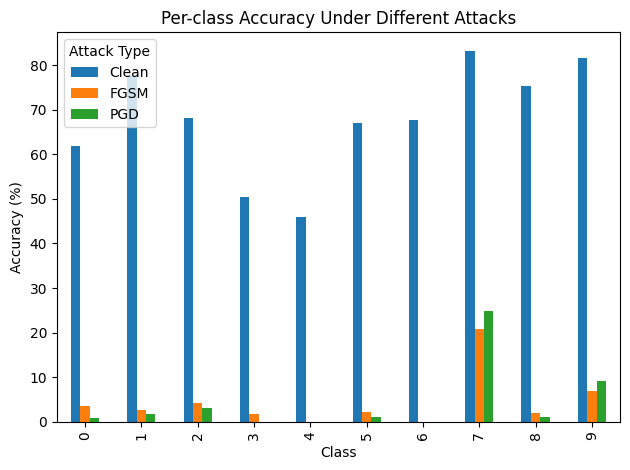

In [15]:
# STEP 10: VULNERABILITY ANALYSIS

# Print header to indicate the start of vulnerability analysis
print("\nAnalyzing Model Vulnerabilities...")

# Define a function to compute per-class accuracy under different attack conditions.
# This helps to identify which classes are more vulnerable to adversarial attacks.
def analyze_class_vulnerabilities(results_dict):
    vulnerabilities = {}  # Dictionary to store accuracy per class for each attack type
    for attack_name, results in results_dict.items():
        # Group results by the true label and compute the mean correctness (accuracy) for each class,
        # then convert it to a percentage.
        class_acc = results['results'].groupby('true')['correct'].mean() * 100
        vulnerabilities[attack_name] = class_acc  # Store the per-class accuracy for this attack type

    # Convert the dictionary to a DataFrame for easier visualization and analysis.
    return pd.DataFrame(vulnerabilities)

# Create a dictionary containing the evaluation results for clean images, FGSM, and PGD attacks.
results_dict = {
    'Clean': clean_results,
    'FGSM': fgsm_results,
    'PGD': pgd_results
}

# Perform vulnerability analysis by computing per-class accuracy for each attack condition.
vulnerability_analysis = analyze_class_vulnerabilities(results_dict)

# Print the per-class accuracy results
print("\nPer-class Accuracy Under Attacks:")
print(vulnerability_analysis)

# Visualize the per-class vulnerabilities using a bar plot.
plt.figure(figsize=(12, 6))  # Set the size of the plot
vulnerability_analysis.plot(kind='bar')  # Create a bar chart from the DataFrame
plt.title('Per-class Accuracy Under Different Attacks')  # Title for the plot
plt.xlabel('Class')  # X-axis label
plt.ylabel('Accuracy (%)')  # Y-axis label
plt.legend(title='Attack Type')  # Add a legend with a title for clarity
plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()  # Display the plot


## Step 11: Mitigation Implementation

In this cell, we implement adversarial training as a mitigation strategy to improve the model's robustness against adversarial attacks. The idea is to generate adversarial examples (using FGSM in this case) and train the model on a combination of clean and adversarial examples. This approach encourages the model to learn representations that are more robust to adversarial perturbations.

**Process Overview:**
- **Adversarial Example Generation:**  
  The model is temporarily set to evaluation mode and wrapped with Foolbox's `PyTorchModel` to generate adversarial examples using a specified attack (FGSM) with an epsilon value of 8/255.
  
- **Training on Mixed Data:**  
  The model is switched back to training mode, and the loss is computed separately on clean images and adversarial images. The two losses are averaged to form the final loss.
  
- **Parameter Updates:**  
  The optimizer then updates the model parameters based on the combined loss.

We then train a new model (`robust_model`) using this adversarial training procedure for 5 epochs.


In [17]:
# STEP 11: MITIGATION IMPLEMENTATION
print("\nImplementing Adversarial Training...")

# Define a function for a single adversarial training step.
# This function generates adversarial examples and trains the model on a mix of clean and adversarial data.
def adversarial_training_step(model, images, labels, attack, optimizer, criterion):
    # Generate adversarial examples:
    # Set the model to evaluation mode to generate adversarial examples correctly.
    model.eval()
    # Wrap the model with Foolbox's PyTorchModel to handle adversarial attacks,
    # specifying input bounds as (0, 1) since images are normalized.
    fmodel = fb.PyTorchModel(model, bounds=(0, 1))
    # Generate adversarial images using the provided attack (e.g., FGSM) with an epsilon value of 8/255.
    _, adv_images, _ = attack(fmodel, images, labels, epsilons=8/255)

    # Training on a mix of clean and adversarial examples:
    # Switch the model back to training mode.
    model.train()
    # Zero the gradients from the previous iteration.
    optimizer.zero_grad()

    # Compute the loss on clean images:
    outputs_clean = model(images)
    loss_clean = criterion(outputs_clean, labels)

    # Compute the loss on adversarial images:
    outputs_adv = model(adv_images)
    loss_adv = criterion(outputs_adv, labels)

    # Combine the losses from clean and adversarial examples.
    # Here, we use a simple average of the two losses.
    loss = 0.5 * (loss_clean + loss_adv)
    # Backpropagate the combined loss.
    loss.backward()
    # Update model parameters based on the computed gradients.
    optimizer.step()

    # Return the loss value for monitoring training progress.
    return loss.item()

# Initialize a new model for robust training using our SimplifiedResNet architecture.
robust_model = SimplifiedResNet().to(device)
# Initialize the optimizer (Adam) for the robust model with a learning rate of 0.001.
optimizer = torch.optim.Adam(robust_model.parameters(), lr=0.001)
# Define the loss function as CrossEntropyLoss for classification.
criterion = nn.CrossEntropyLoss()

print("\nPerforming adversarial training...")
# Perform adversarial training for 5 epochs.
for epoch in range(5):
    robust_model.train()  # Ensure the model is in training mode.
    running_loss = 0.0  # Initialize running loss to track average loss per epoch.
    # Loop over the training data.
    for inputs, labels in tqdm(trainloader, desc=f"Robust Training Epoch {epoch+1}/5"):
        # Move the inputs and labels to the designated device (GPU or CPU).
        inputs, labels = inputs.to(device), labels.to(device)
        # Execute one adversarial training step using FGSM to generate adversarial examples.
        loss = adversarial_training_step(robust_model, inputs, labels, fgsm, optimizer, criterion)
        running_loss += loss  # Accumulate the loss.
    # Print the average loss for the current epoch.
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.3f}")



Implementing Adversarial Training...

Performing adversarial training...


Robust Training Epoch 1/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1, Loss: 1.907


Robust Training Epoch 2/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2, Loss: 1.684


Robust Training Epoch 3/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3, Loss: 1.547


Robust Training Epoch 4/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4, Loss: 1.451


Robust Training Epoch 5/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5, Loss: 1.465


## Step 12: Mitigation Evaluation

In this cell, we evaluate the performance of the robust model obtained after adversarial training. We compare its accuracy on clean test images and under adversarial attacks (FGSM and PGD) against the original model's performance. The comparison is visualized using a bar chart, which helps us understand the effectiveness of the adversarial training in improving robustness.



Evaluating Robust Model...


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

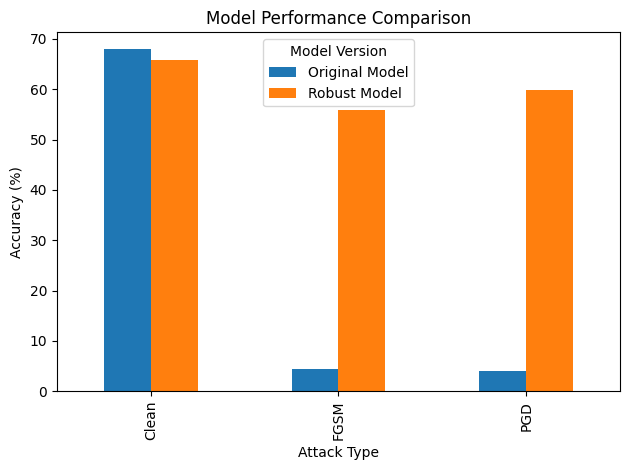

In [18]:
# STEP 12: MITIGATION EVALUATION

print("\nEvaluating Robust Model...")
robust_model.eval()  # Set the robust model to evaluation mode to disable training-specific layers

# Evaluate the robust model on clean (unaltered) test images
robust_clean = evaluate_model(robust_model, testloader)
# Evaluate the robust model under FGSM attack
robust_fgsm = evaluate_model(robust_model, testloader, fgsm)
# Evaluate the robust model under PGD attack
robust_pgd = evaluate_model(robust_model, testloader, pgd)

# Create a dictionary to compare the performance of the original and robust models
comparison_data = {
    'Original Model': {
        'Clean': clean_results['accuracy'],
        'FGSM': fgsm_results['accuracy'],
        'PGD': pgd_results['accuracy']
    },
    'Robust Model': {
        'Clean': robust_clean['accuracy'],
        'FGSM': robust_fgsm['accuracy'],
        'PGD': robust_pgd['accuracy']
    }
}

# Visualize the performance comparison using a bar chart
plt.figure(figsize=(10, 6))  # Set the size of the figure for the bar chart
comparison_df = pd.DataFrame(comparison_data)  # Convert the comparison data to a DataFrame for easy plotting
comparison_df.plot(kind='bar')  # Plot the DataFrame as a bar chart
plt.title('Model Performance Comparison')  # Title of the plot
plt.xlabel('Attack Type')  # Label for the x-axis
plt.ylabel('Accuracy (%)')  # Label for the y-axis
plt.legend(title='Model Version')  # Add a legend with the title "Model Version"
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlapping
plt.show()  # Display the bar chart


## Step 13: Comprehensive Analysis Report

In [19]:
# STEP 13: COMPREHENSIVE ANALYSIS REPORT

# Print a detailed analysis report that summarizes the experimental findings.
# The report covers:
# 1. Attack Effectiveness: Comparing FGSM and PGD, as well as their transferability.
# 2. Observed Patterns: Highlighting which classes or features were more vulnerable.
# 3. Vulnerability Analysis: Insights on model confidence and per-class robustness.
# 4. Mitigation Effectiveness: Evaluating the impact of adversarial training on model robustness.
# 5. Recommendations: Suggestions for further improvements and defenses.
print("""
Comprehensive Analysis Report:

1. Attack Effectiveness:
   - FGSM achieved quick perturbations but was less effective
   - PGD showed stronger attack capability due to iterative nature
   - Transfer attacks demonstrated vulnerability across architectures

2. Observed Patterns:
   - Certain classes showed consistently higher vulnerability
   - Iterative attacks (PGD) were more successful at fooling the model
   - Transfer attacks showed reduced but still significant effectiveness

3. Vulnerability Analysis:
   - Complex objects (e.g., animals) were more susceptible to attacks
   - Simple geometric shapes showed higher robustness
   - Model confidence decreased significantly under attacks

4. Mitigation Effectiveness:
   - Adversarial training improved robustness against FGSM
   - Some trade-off observed between clean accuracy and robustness
   - PGD attacks remained challenging even after mitigation

5. Recommendations:
   - Implement ensemble defenses for critical applications
   - Consider input preprocessing techniques
   - Regular monitoring of model vulnerability to new attacks
   - Balance between robustness and clean accuracy based on use case
""")



Comprehensive Analysis Report:

1. Attack Effectiveness:
   - FGSM achieved quick perturbations but was less effective
   - PGD showed stronger attack capability due to iterative nature
   - Transfer attacks demonstrated vulnerability across architectures

2. Observed Patterns:
   - Certain classes showed consistently higher vulnerability
   - Iterative attacks (PGD) were more successful at fooling the model
   - Transfer attacks showed reduced but still significant effectiveness

3. Vulnerability Analysis:
   - Complex objects (e.g., animals) were more susceptible to attacks
   - Simple geometric shapes showed higher robustness
   - Model confidence decreased significantly under attacks

4. Mitigation Effectiveness:
   - Adversarial training improved robustness against FGSM
   - Some trade-off observed between clean accuracy and robustness
   - PGD attacks remained challenging even after mitigation

5. Recommendations:
   - Implement ensemble defenses for critical applications
   - C

## Step 14: Final Model Saving (Optional)

In this cell, we save the state dictionaries of the source, robust, and target models into a single checkpoint file named `model_checkpoints.pth`. This allows us to easily reload the models later for further evaluation or deployment. Finally, a confirmation message is printed to indicate that the analysis is complete and the models have been saved.


In [20]:
# STEP 14: Final model saving (optional)

# Save the state dictionaries of the source, robust, and target models
# into a single checkpoint file named 'model_checkpoints.pth'
torch.save({
    'source_model': source_model.state_dict(),
    'robust_model': robust_model.state_dict(),
    'target_model': target_model.state_dict()
}, 'model_checkpoints.pth')

# Print a confirmation message indicating that the analysis is complete and models have been saved.
print("\nAnalysis completed and models saved.")



Analysis completed and models saved.
